In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def kernel_rbf(a, b, L):

    if not isinstance(a, np.ndarray) or a.ndim != 2:
        raise ValueError(f"Input 'a' must be a 2D numpy array. Got shape {a.shape}")
    if not isinstance(b, np.ndarray) or b.ndim != 2:
        raise ValueError(f"Input 'b' must be a 2D numpy array. Got shape {b.shape}")
    if a.shape[1] != b.shape[1]:
        raise ValueError(f"Inputs 'a' and 'b' must have the same number of features (columns). "
                         f"Got a.shape[1] = {a.shape[1]} and b.shape[1] = {b.shape[1]}")
    if not (isinstance(L, (int, float)) and L > 0):
        raise ValueError(f"Parameter 'L' must be a positive number. Got {L}")
    sq_dists = np.ones((a.shape[0], b.shape[0]))
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            sq_dists[i, j] = np.power(np.linalg.norm(a[i, :] - b[j, :], 2), 2)
    return np.exp(-L * sq_dists)

In [3]:
class GaussianProcessRegressorRBF: 


    def __init__(self, kernel_L, sigma_sq_process, input_dim=1):
        
        self.kernel_L = kernel_L
        self.sigma_sq_process = sigma_sq_process  
        self.input_dim = input_dim


    def load_data(self, x, y):

        n = x.shape[0]
        self.x_vect = np.array([x]).reshape(n, self.input_dim)
        self.y_vect = np.array([y]).reshape(n, 1)
    
        self.K_matrix = kernel_rbf(self.x_vect, self.x_vect, self.kernel_L) + self.sigma_sq_process * np.eye(n)
        self.K_matrix_inv, _, _, _ = np.linalg.lstsq(self.K_matrix, np.eye(n))
        # np.linalg.solve(self.K_matrix, np.eye(n)) # np.linalg.inv(self.K_matrix)
        
    
    def compute(self, x):
        
        assert x.ndim == 2 and x.shape[1] == self.input_dim, "compute(): input error"
        
        n = x.shape[0]
        mu = np.zeros(n)
        sigma = np.zeros(n)
        
        for i in range(n):
            K_star = kernel_rbf(self.x_vect, x[i, :].reshape(1, self.input_dim), self.kernel_L)
            mu[i] = K_star.T @ self.K_matrix_inv @ self.y_vect
            sigma[i] = kernel_rbf(x[i, :].reshape(1, self.input_dim), x[i, :].reshape(1, self.input_dim), self.kernel_L) - K_star.T @ self.K_matrix_inv @ K_star

        return mu, sigma

In [4]:
class HeteroscedasticGaussianProcessRegressorRBF: 


    def __init__(self, kernel_L, sigma_sq_process, input_dim=1):

        self.kernel_L = kernel_L
        self.sigma_sq_process = sigma_sq_process  
        self.input_dim = input_dim


    def load_data(self, x, y, sigmasqs):

        n = x.shape[0]
        
        self.x_vect = np.array([x]).reshape(n, self.input_dim)
        self.y_vect = np.array([y]).reshape(n, 1)
        self.sigmasqs = np.array([sigmasqs]).reshape(n,)
        
        self.K_matrix = kernel_rbf(self.x_vect, self.x_vect, self.kernel_L) + np.diag(self.sigmasqs)
        self.K_matrix_inv = np.linalg.solve(self.K_matrix, np.eye(n))


    def compute(self, x):

        assert x.ndim == 2, "compute(): input error"
        assert x.shape[1] == self.input_dim, "compute(): input error"
        
        n = x.shape[0]
        mu = np.zeros(n)
        sigmasq = np.zeros(n)
        
        for i in range(n):
            
            K_star = kernel_rbf(self.x_vect, x[i, :].reshape(1, self.input_dim), self.kernel_L)
            mu[i] = K_star.T @ self.K_matrix_inv @ self.y_vect
            sigmasq[i] = kernel_rbf(x[i, :].reshape(1, self.input_dim), x[i, :].reshape(1, self.input_dim), 
                                    self.kernel_L) - K_star.T @ self.K_matrix_inv @ K_star

        return mu, sigmasq

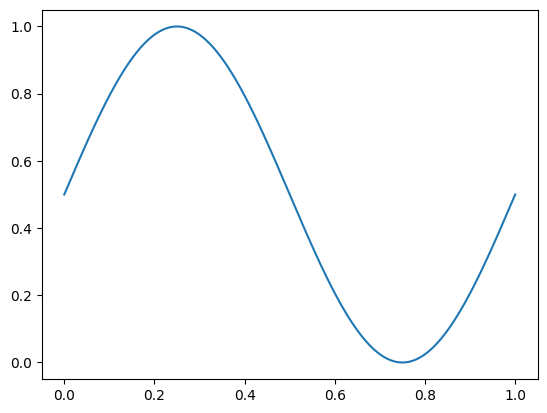

In [5]:
def true_function(vect):
    return 0.5 * np.sin(vect * 2 * math.pi) + 0.5

x_plt = np.linspace(0, 1, 1000)
plt.plot(x_plt, true_function(x_plt))

In [6]:
n_actions_lst = [10]
n_repetitions_lst = [10]
lmdb_lst = [1e-10, 1e-20, 1e-30, 1e-40]
kernel_L = 10

/var/folders/4z/mvrgdd8923g26xd4nhj_0gdh0000gn/T/ipykernel_17208/1532486566.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.K_matrix_inv, _, _, _ = np.linalg.lstsq(self.K_matrix, np.eye(n))


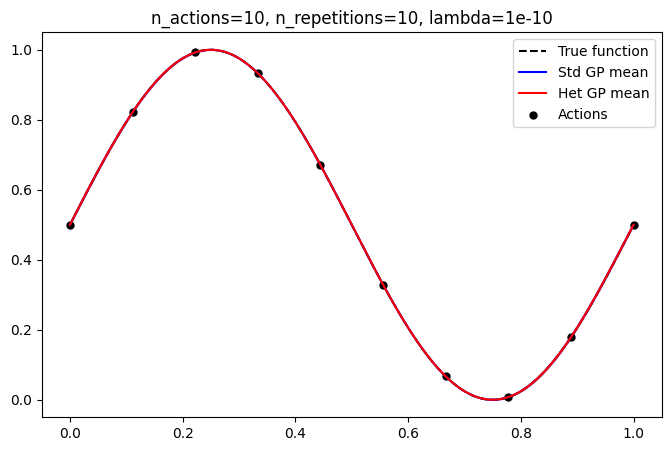

Error Std GP (lambda=1e-10, n=10, rep=10): 0.000000
Error Het GP (lambda=1e-10, n=10, rep=10): 0.000000
--------------------------------------------------------------


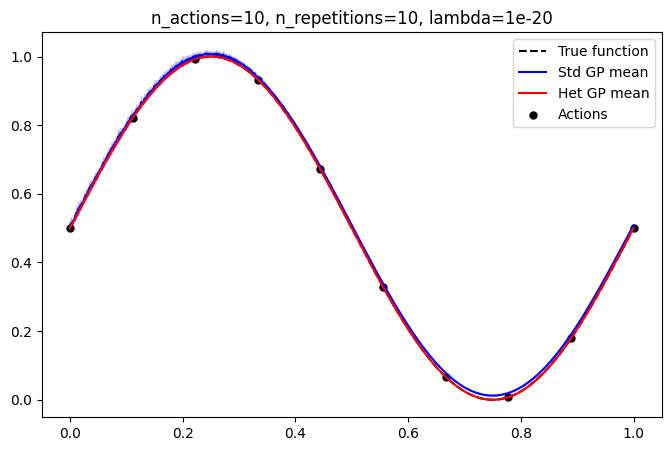

Error Std GP (lambda=1e-20, n=10, rep=10): 0.000075
Error Het GP (lambda=1e-20, n=10, rep=10): 0.000000
--------------------------------------------------------------


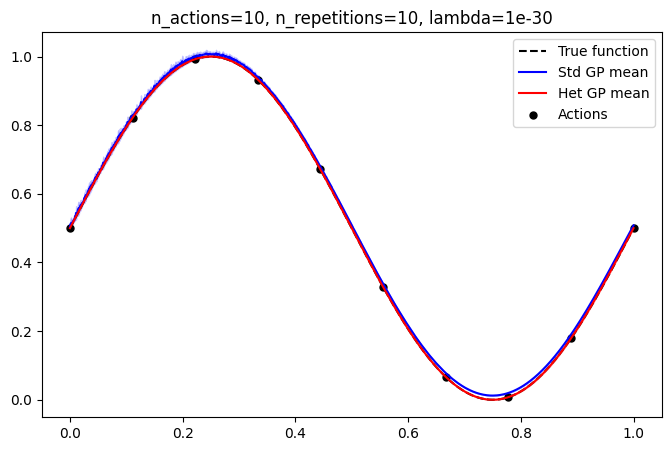

Error Std GP (lambda=1e-30, n=10, rep=10): 0.000075
Error Het GP (lambda=1e-30, n=10, rep=10): 0.000000
--------------------------------------------------------------


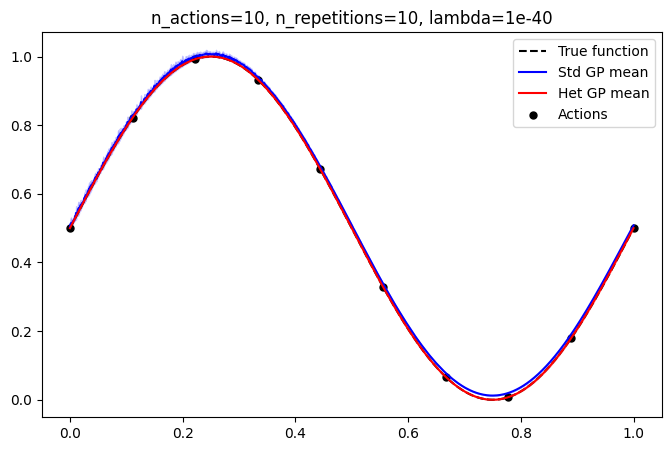

Error Std GP (lambda=1e-40, n=10, rep=10): 0.000075
Error Het GP (lambda=1e-40, n=10, rep=10): 0.000000
--------------------------------------------------------------


In [7]:
for n_actions in n_actions_lst:

    for n_repetitions in n_repetitions_lst:

        for lmdb in lmdb_lst:

            # print(f"Running GPs with {n_actions} actions and {n_repetitions} repetitions considering regularization {lmdb}")
            
            actions_set_ravel = np.linspace(0, 1, n_actions)
            actions_set_colvect = actions_set_ravel.reshape(n_actions, 1)

            gpregressor = GaussianProcessRegressorRBF(kernel_L, lmdb)
            hetgpregressor = HeteroscedasticGaussianProcessRegressorRBF(kernel_L, lmdb)

            actions_set_repeated_ravel = np.repeat(actions_set_ravel, n_repetitions, axis=0)
            actions_set_repeated_colvect = actions_set_repeated_ravel.reshape(n_actions * n_repetitions, 1)

            y_real = true_function(actions_set_ravel)
            y_real_repeated = true_function(actions_set_repeated_ravel)
            
            gpregressor.load_data(actions_set_repeated_colvect, y_real_repeated)
            hetgpregressor.load_data(actions_set_colvect, y_real, lmdb / n_repetitions * np.ones((n_actions)))

            # === confronto dei modelli su 1000 punti (plot mu e sigma) ===
            x_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
            mu_gp, sigma_gp = gpregressor.compute(x_plot)
            mu_het, sigma_het = hetgpregressor.compute(x_plot)

            plt.figure(figsize=(8, 5))
            plt.plot(x_plot, true_function(x_plot), 'k--', label='True function')
            plt.plot(x_plot, mu_gp, 'b', label='Std GP mean')
            plt.fill_between(x_plot.ravel(), mu_gp - sigma_gp, mu_gp + sigma_gp, color='b', alpha=0.2)
            plt.plot(x_plot, mu_het, 'r', label='Het GP mean')
            plt.fill_between(x_plot.ravel(), mu_het - sigma_het, mu_het + sigma_het, color='r', alpha=0.2)
            plt.scatter(actions_set_colvect, y_real[:n_actions], color='k', s=25, label='Actions')
            plt.title(f"n_actions={n_actions}, n_repetitions={n_repetitions}, lambda={lmdb}")
            plt.legend()
            plt.show()

            # === SECONDA CHIAMATA: compute sui punti delle azioni e calcolo errore ===
            mu_gp_actions, _ = gpregressor.compute(actions_set_colvect)
            mu_het_actions, _ = hetgpregressor.compute(actions_set_colvect)

            true_vals = true_function(actions_set_ravel)

            err_gp = np.mean((mu_gp_actions - true_vals)**2)
            err_het = np.mean((mu_het_actions - true_vals)**2)

            print(f"Error Std GP (lambda={lmdb}, n={n_actions}, rep={n_repetitions}): {err_gp:.6f}")
            print(f"Error Het GP (lambda={lmdb}, n={n_actions}, rep={n_repetitions}): {err_het:.6f}")
            print("--------------------------------------------------------------")